In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.graph import KGraphPreproc
from utils.evaluation import CWQ_Dataset
from utils.plot import get_broken_figure
import networkx as nx
from utils.scores import calculate_em_accuracy, calculate_f1_accuracy, get_rouge_score_for_answers
import numpy as np
import ast

In [36]:
fbkb_graph = KGraphPreproc.get_fbkb_graph()

In [78]:
def get_path_len(row):
    for start in row.topic_ids:
        for target in row.answer_ids:
            try:
                if nx.has_path(fbkb_graph._graph, start, target):
                    return nx.shortest_path_length(fbkb_graph._graph, start, target)
            except nx.NodeNotFound:
                continue
    return -1

In [79]:
cwq_eval = CWQ_Dataset()

In [80]:
cwq_eval.tabulate_performance()

CWQ
+-----------+-------+-------+
|           |    EM |    F1 |
+===========+=======+=======+
| bline     | 0.277 | 0.298 |
+-----------+-------+-------+
| bline2    | 0.281 | 0.299 |
+-----------+-------+-------+
| kb-path   | 0.583 | 0.647 |
+-----------+-------+-------+
| kb1       | 0.251 | 0.311 |
+-----------+-------+-------+
| kb2       | 0.257 | 0.322 |
+-----------+-------+-------+
| kb3       | 0.261 | 0.327 |
+-----------+-------+-------+
| kb4       | 0.26  | 0.325 |
+-----------+-------+-------+
| kb5       | 0.263 | 0.323 |
+-----------+-------+-------+
| kb6       | 0.269 | 0.332 |
+-----------+-------+-------+
| kb7       | 0.265 | 0.325 |
+-----------+-------+-------+
| sbert-kb1 | 0.324 | 0.344 |
+-----------+-------+-------+
| sbert-kb2 | 0.344 | 0.338 |
+-----------+-------+-------+
| sbert-kb3 | 0.351 | 0.344 |
+-----------+-------+-------+
| sbert-kb4 | 0.358 | 0.345 |
+-----------+-------+-------+
| sbert-kb5 | 0.344 | 0.339 |
+-----------+-------+-------+
| sber

In [81]:
cwq_tset = cwq_eval.test_set.copy()
cwq_tset["hops"] = cwq_tset.apply(get_path_len, axis=1)

In [82]:
cwq_tset.head(1)

,ID,compositionality_type,question,answers,topic_ids,answer_ids,hops
894,WebQTest-1311_e920e31a99d6b7dfbeef110668d3103d,comparative,What inspiration of Antoni Gaudi died later th...,"[{'aliases': ['W. Morris'], 'answer': 'William...","[/m/0g84t93, /m/0g84t93, /m/0g84t93, /m/0g84t9...",[/m/08304],5


In [83]:
cwq_tset.question.iloc[5]

'Which Miley Cyrus movies were released after 12/10/2003?'

In [87]:
# load model answers
for r_set in cwq_eval.result_set_paths:
    set_name = r_set.split("/")[-1].split(".")[0]
    cwq_tset["Actual"] = cwq_eval.answers
    result_df = pd.read_csv(r_set, dtype=str, index_col=0)
    result_df.rename(columns={1: "Model"}, inplace=True)
    # 
    values = result_df.Model.apply(lambda s: str(s).lower().split(",")).values
    values = np.pad(values, (0, 1000 - values.size), constant_values="")
    # 
    cwq_tset[set_name] = values
    # print(cwq_tset)
    cwq_tset[f"{set_name}_EM"] = cwq_tset.apply(lambda row: calculate_em_accuracy(row["Actual"], row[set_name]), axis=1)
    cwq_tset[f"{set_name}_F1"] = cwq_tset.apply(lambda row: calculate_f1_accuracy(row["Actual"], row[set_name]), axis=1)
    cwq_tset[f"{set_name}_correct"] = cwq_tset.apply(lambda t: get_rouge_score_for_answers(t.Actual, t[set_name]) >= 0.5, axis=1)
cwq_tset.head(2)

,ID,compositionality_type,question,answers,topic_ids,answer_ids,hops,Actual,bline,bline_EM,...,sbert-kb6_F1,sbert-kb6_correct,sbert-kb7,sbert-kb7_EM,sbert-kb7_F1,sbert-kb7_correct,tog-lp-4,tog-lp-4_EM,tog-lp-4_F1,tog-lp-4_correct
894,WebQTest-1311_e920e31a99d6b7dfbeef110668d3103d,comparative,What inspiration of Antoni Gaudi died later th...,"[{'aliases': ['W. Morris'], 'answer': 'William...","[/m/0g84t93, /m/0g84t93, /m/0g84t93, /m/0g84t9...",[/m/08304],5,[william morri],"[park güell, sagrada família, casa batlló, ...",0,...,0.0,False,[nan],0,0.0,False,[('antoni gaudi did not appear in the given co...,0,0.000000,False
1329,WebQTest-1382_b9b879060be6df6cb7cd937a7996f9d9,comparative,What country borders Argentina and has an army...,"[{'aliases': ['Brazilian ', 'República Federat...","[/m/0g84t93, /m/0g84t93, /m/02lw5z, /m/0g84t93...",[/m/015fr],5,[brazil],"[brazil, chile]",1,...,1.0,True,[nan],0,0.0,False,"[('brazil, chile', 3)]",1,0.333333,False


In [88]:
cwq_tset[["Actual", "bline"]]

,Actual,bline
894,[william morri],"[park güell, sagrada família, casa batlló, ..."
1329,[brazil],"[brazil, chile]"
1235,"[brazil, paraguay, bolivia, chile, uruguay]","[bolivia, paraguay, uruguay, chile]"
1778,[benin],"[mali, guinea, nigeria]"
1471,"[harvard colleg, columbia law school, harvard ...",[radcliffe college (1879) and yale university ...
...,...,...
2898,[brazil],[chile (56)]
3254,[templ univers],[temple university]
1901,[minneapoli],[big pink (gnis feature id: 1640501)]
2507,[abraham lincoln],"[richard nixon, ronald reagan]"


In [89]:
set_names = [r.split("/")[-1].split(".")[0] for r in cwq_eval.result_set_paths]
set_names

['bline',
 'bline2',
 'kb-path',
 'kb1',
 'kb2',
 'kb3',
 'kb4',
 'kb5',
 'kb6',
 'kb7',
 'sbert-kb1',
 'sbert-kb2',
 'sbert-kb3',
 'sbert-kb4',
 'sbert-kb5',
 'sbert-kb6',
 'sbert-kb7',
 'tog-lp-4']

In [90]:
cwq_res = cwq_tset[
    ["hops", "compositionality_type",
    *[s+"_EM" for s in set_names], 
    *[s+"_correct" for s in set_names],
    *[s+"_F1" for s in set_names],
]
]
cwq_res.head(2)


,hops,compositionality_type,bline_EM,bline2_EM,kb-path_EM,kb1_EM,kb2_EM,kb3_EM,kb4_EM,kb5_EM,...,kb6_F1,kb7_F1,sbert-kb1_F1,sbert-kb2_F1,sbert-kb3_F1,sbert-kb4_F1,sbert-kb5_F1,sbert-kb6_F1,sbert-kb7_F1,tog-lp-4_F1
894,5,comparative,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1329,5,comparative,1,1,1,1,1,1,1,1,...,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.333333


In [91]:
def cast_to_float(x):
    try:
        return float(x)
    except:
        return 0

In [92]:
data = cwq_tset[cwq_tset["hops"] < 7].applymap(cast_to_float).groupby(by="hops").sum()
data["total"] = cwq_tset.applymap(cast_to_float).groupby(by="hops").apply(lambda t: len(t))
for s in set_names:
    data[f"{s}_p"] = round(data[f"{s}_EM"] / data["total"], 3)
    data[f"{s}_fp"] = round(data[f"{s}_F1"] / data["total"], 3)
    data[f"{s}_cp"] = round(data[f"{s}_correct"] / data["total"], 3)
data.head(1)

/tmp/ipykernel_359/4257040557.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = cwq_tset[cwq_tset["hops"] < 7].applymap(cast_to_float).groupby(by="hops").sum()
/tmp/ipykernel_359/4257040557.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data["total"] = cwq_tset.applymap(cast_to_float).groupby(by="hops").apply(lambda t: len(t))
/tmp/ipykernel_359/4257040557.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data["total"] = cwq_tset.applymap(cast_to_float).groupby(by="hops").apply(lambda t: len(t))


,ID,compositionality_type,question,answers,topic_ids,answer_ids,Actual,bline,bline_EM,bline_F1,...,sbert-kb5_cp,sbert-kb6_p,sbert-kb6_fp,sbert-kb6_cp,sbert-kb7_p,sbert-kb7_fp,sbert-kb7_cp,tog-lp-4_p,tog-lp-4_fp,tog-lp-4_cp
hops,,,,,,,,,,,,,,,,,,,,,
4.0,0,0,0,0,0,0,0,0,9.0,25.444409,...,0.274,0.0,0.0,0.0,0.0,0.0,0.0,0.106,0.103,0.097


In [93]:
data[["Actual", "bline"]]

,Actual,bline
hops,,
4.0,0,0
5.0,0,0
6.0,0,0


In [94]:
data[
    ["total", 
     *[f"{s}_p" for s in set_names[:1]], 
     *[f"{s}_cp" for s in set_names[:1]], 
     *[f"{s}_fp" for s in set_names[:1]]
    ]
]

,total,bline_p,bline_cp,bline_fp
hops,,,,
4.0,113,0.080,0.398,0.225
5.0,779,0.306,0.370,0.309
6.0,106,0.283,0.462,0.295


In [95]:
data[
    [
        "total", 
        # *[f"{s}_p" for s in set_names[1:]], 
        *[f"{s}_correct" for s in set_names[:1]], 
        # *[f"{s}_fp" for s in set_names[1:]]
    ]
].stack(future_stack=True)

hops               
4.0   total            113.0
      bline_correct     45.0
5.0   total            779.0
      bline_correct    288.0
6.0   total            106.0
      bline_correct     49.0
dtype: float64

In [96]:
data.index

Index([4.0, 5.0, 6.0], dtype='float64', name='hops')

In [97]:
def get_n_data(data, set_name, delta=0, col_name="p"):
    if set_name == "tog-lp":
        return data[f"tog-lp-4_{col_name}"]
        
    return [
        data.loc[hop, f"{set_name}{int(hop)+delta}_{col_name}"]
        for hop in data.index
    ]

In [98]:
cwq_sota = [0.4744, 0.5900, 0.4789, 0.4196]
cwq_avg_sota = round(np.average(cwq_sota), 3)
print(cwq_avg_sota)

def plot_sota(ax, lower=4, upper=6):
    ax.hlines(cwq_avg_sota, lower, upper, colors="black", linestyles="dashed", label="SOTA")

0.491


baseline 0.222 kb-path 0.553


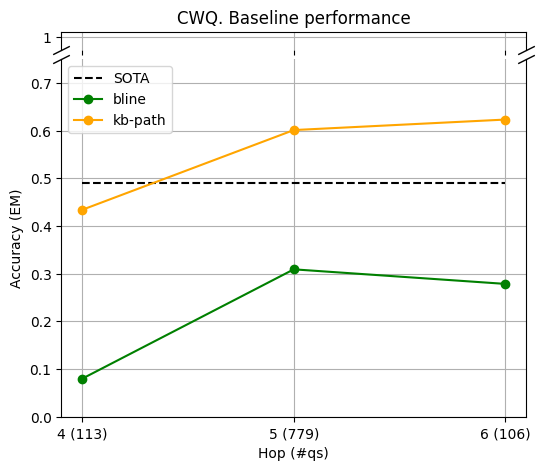

In [99]:
colors = {
    "bline": "green",
    "kb-path": "orange",
}

# fig, ax = plt.subplots(figsize=(4,3))
fig, tax, ax = get_broken_figure(top_lim=0.75)

datas = {
    "bline": data[["bline_p", "bline2_p"]].mean(axis=1),
    "kb-path": data["kb-path_p"].values,
}
# 
plot_sota(ax)
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{int(i)} ({data.loc[i, 'total']})" for i in data.index.values])

# ax.set_ylim(0, 1.1)
# plt.tight_layout(pad=1)
tax.set_title("CWQ. Baseline performance")
plt.xlabel("Hop (#qs)")
ax.set_ylabel("Accuracy (EM)")
ax.legend()
ax.grid()
print(
    "baseline", data[["bline_p", "bline2_p"]].mean(axis=1).mean().round(3),
    "kb-path", data["kb-path_p"].mean().round(3),
)
# Display the plot
plt.show()


n-1
0.207
n
0.214
n+1
0.214


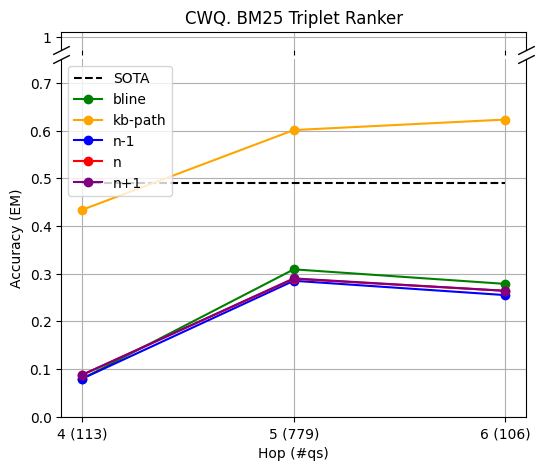

In [100]:
colors = {
    "bline": "green",
    "kb-path": "orange",
    # "kb1_p": "blue",
    # "kb2_p": "red",
    # "kb3_p": "purple",
    # "kb4_p": "brown",
    # "kb5_p": "pink",
    # "kb6_p": "olive",
    "n-1": "blue",
    "n": "red",
    "n+1": "purple",
}

fig, tax, ax = get_broken_figure(top_lim=0.75)

nm1_data = get_n_data(data, "kb", -1)
ndata = get_n_data(data, "kb", 0)
np1_data = get_n_data(data, "kb", 1)

datas = {
    "bline": data[["bline_p", "bline2_p"]].mean(axis=1),
    "kb-path": data["kb-path_p"].values,
    "n-1": nm1_data,
    "n": ndata,
    "n+1": np1_data,
}
# 
# kwargs = dict(transform=ax.transAxes, clip_on=False)
plot_sota(ax)

for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
        # **kwargs,
         
    )
plt.xticks(data.index.values.astype(int), [f"{int(i)} ({data.loc[i, 'total']})" for i in data.index.values])


tax.set_title("CWQ. BM25 Triplet Ranker")
plt.xlabel("Hop (#qs)")
ax.set_ylabel("Accuracy (EM)")
ax.grid()
ax.legend()
print(
    "n-1", round(sum(nm1_data) / len(nm1_data), 3),
    "n", round(sum(ndata) / len(ndata), 3),
    "n+1", round(sum(np1_data) / len(np1_data), 3),
    sep="\n"
)
# Display the plot
plt.show()


n-1
0.308
n
0.319
n+1
0.333


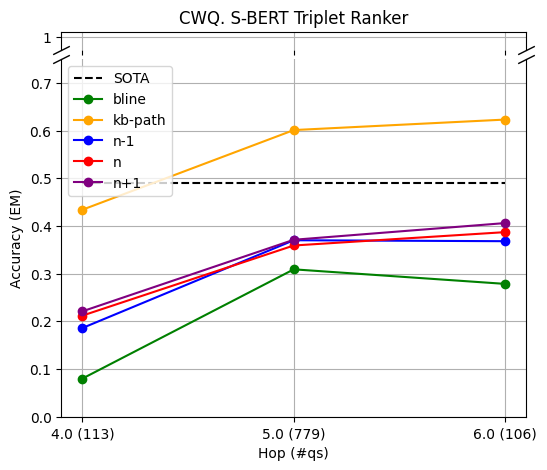

In [101]:
colors = {
    "bline": "green",
    "kb-path": "orange",
    "kb1": "blue",
    "kb2": "red",
    "kb3": "purple",
    # "sbert-kb1": "blue",
    # "sbert-kb2": "red",
    # "sbert-kb3": "purple",
    # "sbert-kb4": "brown",
    # "kb4_p": "brown",
    # "kb5_p": "pink",
    # "kb6_p": "olive",
    "n-1": "blue",
    "n": "red",
    "n+1": "purple",
}
nm1_data = get_n_data(data, "sbert-kb", -1)
ndata = get_n_data(data, "sbert-kb", 0)
np1_data = get_n_data(data, "sbert-kb", 1)

datas = {
    "bline": data[["bline_p", "bline2_p"]].mean(axis=1),
    "kb-path": data["kb-path_p"].values,
    "n-1": nm1_data,
    "n": ndata,
    "n+1": np1_data,
}

fig, tax, ax = get_broken_figure(top_lim=0.75)
# 
plot_sota(ax)
# 
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{i} ({data.loc[i, 'total']})" for i in data.index.values])
# 

tax.set_title("CWQ. S-BERT Triplet Ranker")
plt.xlabel("Hop (#qs)")
ax.set_ylabel("Accuracy (EM)")
ax.grid()
ax.legend()
print(
    "n-1", round(sum(nm1_data) / len(nm1_data), 3),
    "n", round(sum(ndata) / len(ndata), 3),
    "n+1", round(sum(np1_data) / len(np1_data), 3),
    sep="\n"
)
# Display the plot
plt.show()


In [24]:
data.columns

Index(['ID', 'compositionality_type', 'question', 'answers', 'topic_ids',
       'answer_ids', 'Actual', 'bline', 'bline_EM', 'bline_F1',
       ...
       'sbert-kb5_cp', 'sbert-kb6_p', 'sbert-kb6_fp', 'sbert-kb6_cp',
       'sbert-kb7_p', 'sbert-kb7_fp', 'sbert-kb7_cp', 'tog-lp-4_p',
       'tog-lp-4_fp', 'tog-lp-4_cp'],
      dtype='object', length=134)

bm25
0.214
sbert
0.319
tog-lp
0.162


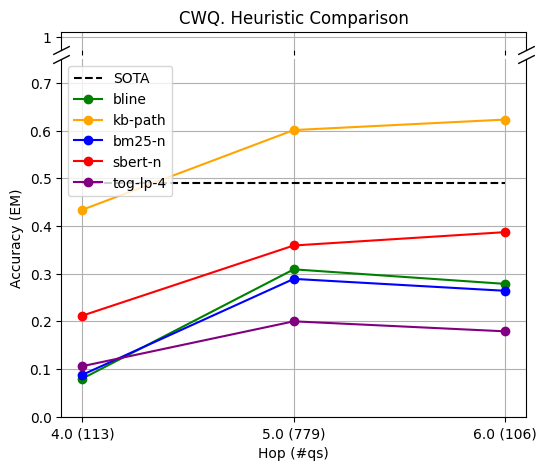

In [66]:
# "": data["tog-lp-1_p"].values
colors = {
    "bline": "green",
    "kb-path": "orange",
    "bm25-n": "blue",
    "sbert-n": "red",
    "tog-lp-4": "purple",
    # "kb4_p": "brown",
    # "kb5_p": "pink",
    # "kb6_p": "olive",
}

fig, tax, ax = get_broken_figure(top_lim=0.75)


bm25 = get_n_data(data, "kb", 0)
sbert = get_n_data(data, "sbert-kb", 0)
# sbert = data["sbert-kb3_p"].values

datas = {
    "bline": data[["bline_p", "bline2_p"]].mean(axis=1),
    "kb-path": data["kb-path_p"].values,
    "bm25-n": bm25,
    "sbert-n": sbert,
    "tog-lp-4": data["tog-lp-4_p"]
}
# 
plot_sota(ax)
for j,k in enumerate(datas.keys()):
    ax.plot(
        data.index.values.astype(int), datas[k],
        color=colors[k], label=k, marker="o",
         
    )
plt.xticks(data.index.values.astype(int), [f"{i} ({data.loc[i, 'total']})" for i in data.index.values])

tax.set_title("CWQ. Heuristic Comparison")
plt.xlabel("Hop (#qs)")
plt.ylabel("Accuracy (EM)")
plt.legend()
plt.grid()
print(
    "bm25", round(sum(bm25) / len(bm25), 3),
    "sbert", round(sum(sbert) / len(sbert), 3),
    "tog-lp", round(sum(data["tog-lp-4_p"]) / len(data["tog-lp-4_p"]), 3),
    sep="\n"
)
# Display the plot
plt.show()


### Breakdown by question type

In [26]:
cwq_res.groupby("compositionality_type").mean()

,hops,bline_EM,bline2_EM,kb-path_EM,kb1_EM,kb2_EM,kb3_EM,kb4_EM,kb5_EM,kb6_EM,...,kb6_F1,kb7_F1,sbert-kb1_F1,sbert-kb2_F1,sbert-kb3_F1,sbert-kb4_F1,sbert-kb5_F1,sbert-kb6_F1,sbert-kb7_F1,tog-lp-4_F1
compositionality_type,,,,,,,,,,,,,,,,,,,,,
comparative,5.180,0.340,0.30,0.590,0.3400,0.3400,0.3400,0.3300,0.3600,0.3500,...,0.311608,0.334022,0.316845,0.290520,0.333111,0.300132,0.306305,0.308407,0.034382,0.118761
composition,4.955,0.235,0.24,0.560,0.2075,0.2075,0.2100,0.1950,0.2025,0.2125,...,0.305379,0.304285,0.324743,0.305891,0.308844,0.320389,0.307162,0.252409,0.036994,0.123859
conjunction,4.970,0.320,0.33,0.615,0.3025,0.3075,0.3225,0.3275,0.3225,0.3275,...,0.388118,0.373142,0.407538,0.408273,0.394816,0.398646,0.398294,0.374468,0.048631,0.146079
superlative,5.090,0.210,0.23,0.540,0.1300,0.1700,0.1400,0.1800,0.1700,0.1800,...,0.231675,0.210595,0.197616,0.228547,0.290146,0.272249,0.265796,0.255269,0.010970,0.068105


## Group by question type


In [52]:
hop_stats = cwq_res.groupby(by="compositionality_type").sum()
hop_stats["total"] = cwq_res.groupby(by="compositionality_type").apply(lambda t: len(t))
for rset in set_names:
    hop_stats[f"{rset}_p"] = round(hop_stats[f"{rset}_EM"] / hop_stats["total"], 3)
hop_stats

/tmp/ipykernel_359/2836564688.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hop_stats["total"] = cwq_res.groupby(by="compositionality_type").apply(lambda t: len(t))


,hops,bline_EM,bline2_EM,kb-path_EM,kb1_EM,kb2_EM,kb3_EM,kb4_EM,kb5_EM,kb6_EM,...,kb6_p,kb7_p,sbert-kb1_p,sbert-kb2_p,sbert-kb3_p,sbert-kb4_p,sbert-kb5_p,sbert-kb6_p,sbert-kb7_p,tog-lp-4_p
compositionality_type,,,,,,,,,,,,,,,,,,,,,
comparative,518,34,30,59,34,34,34,33,36,35,...,0.350,0.360,0.450,0.460,0.530,0.500,0.480,0.500,0.110,0.230
composition,1982,94,96,224,83,83,84,78,81,85,...,0.212,0.208,0.248,0.258,0.268,0.272,0.258,0.225,0.030,0.152
conjunction,1988,128,132,246,121,123,129,131,129,131,...,0.328,0.322,0.408,0.422,0.405,0.422,0.412,0.408,0.042,0.228
superlative,509,21,23,54,13,17,14,18,17,18,...,0.180,0.170,0.170,0.260,0.290,0.300,0.280,0.270,0.030,0.120


In [53]:
print("CWQ")
data = hop_stats[["total", *[s+"_p" for s in set_names]]]
data

CWQ


,total,bline_p,bline2_p,kb-path_p,kb1_p,kb2_p,kb3_p,kb4_p,kb5_p,kb6_p,kb7_p,sbert-kb1_p,sbert-kb2_p,sbert-kb3_p,sbert-kb4_p,sbert-kb5_p,sbert-kb6_p,sbert-kb7_p,tog-lp-4_p
compositionality_type,,,,,,,,,,,,,,,,,,,
comparative,100,0.340,0.30,0.590,0.340,0.340,0.340,0.330,0.360,0.350,0.360,0.450,0.460,0.530,0.500,0.480,0.500,0.110,0.230
composition,400,0.235,0.24,0.560,0.208,0.208,0.210,0.195,0.202,0.212,0.208,0.248,0.258,0.268,0.272,0.258,0.225,0.030,0.152
conjunction,400,0.320,0.33,0.615,0.302,0.308,0.322,0.328,0.322,0.328,0.322,0.408,0.422,0.405,0.422,0.412,0.408,0.042,0.228
superlative,100,0.210,0.23,0.540,0.130,0.170,0.140,0.180,0.170,0.180,0.170,0.170,0.260,0.290,0.300,0.280,0.270,0.030,0.120


In [54]:
(0.248 + 0.111 + 0.157 + 0.132) / 4

0.162

In [64]:
cwq_res.iloc[0].name

894

comparative
example Which college Derek Fisher attended is a university with more than 3904 postgraduates enrolled?
bline	0.15	kb-path	0.283	bm25	0.164	sbert	0.262	tog	0.248
composition
example What actress plays Claire on a television show with the theme song 'Lonely Girl'?
bline	0.177	kb-path	0.576	bm25	0.151	sbert	0.269	tog	0.111
conjunction
example In what country is Arabic spoken and is the birthplace of Barbara Starr?
bline	0.213	kb-path	0.43	bm25	0.473	sbert	0.275	tog	0.157
superlative
example Which location has the Illinois river on a map and has the newest governmental jurisdiction?
bline	0.212	kb-path	0.423	bm25	0.113	sbert	0.17	tog	0.132


/tmp/ipykernel_359/665950575.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  q_data["total"] = q_type_data.groupby(by="hops").apply(lambda t: len(t))
/tmp/ipykernel_359/665950575.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  q_data["total"] = q_type_data.groupby(by="hops").apply(lambda t: len(t))
/tmp/ipykernel_359/665950575.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the group

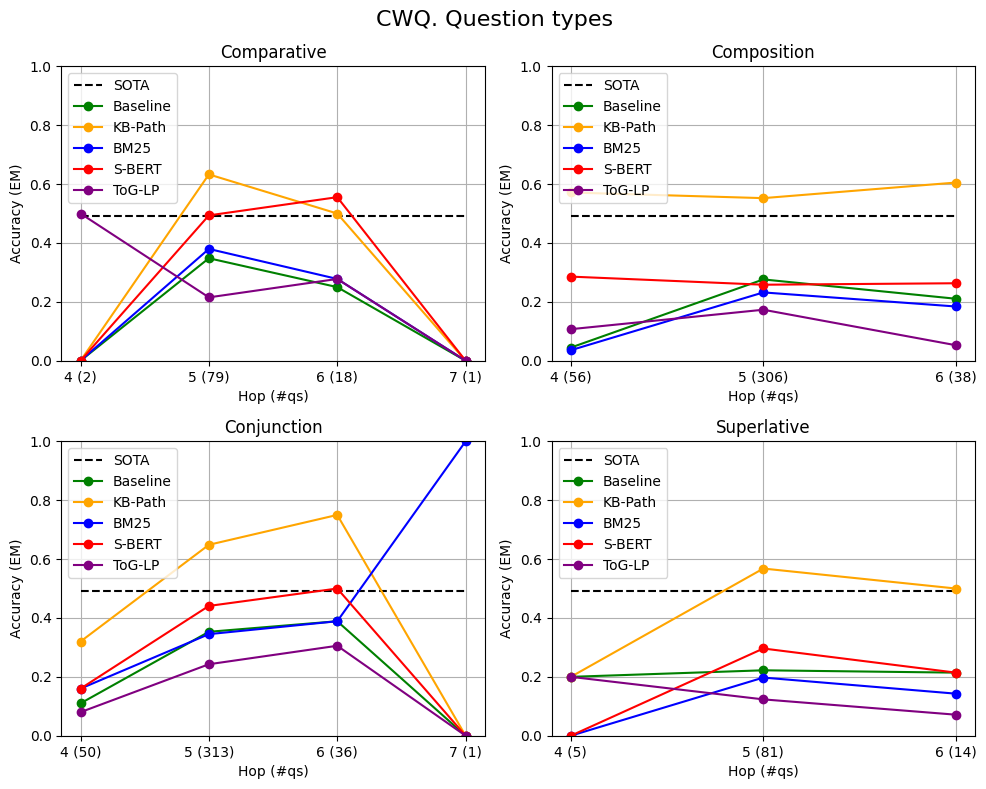

In [73]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))


for i,q_type in enumerate(hop_stats.index):
    ax = axs[i//2, i%2]
    print(q_type)
    q_type_data = cwq_res[cwq_res["compositionality_type"] == q_type][["hops", *[s+"_EM" for s in set_names]]]
    # display(q_type_data)
    q_data = q_type_data.groupby(by="hops").mean()
    q_data["total"] = q_type_data.groupby(by="hops").apply(lambda t: len(t))
    # display(q_data)

    bline = q_data[["bline_EM", "bline2_EM"]].mean(axis=1)
    kb_path = q_data["kb-path_EM"].values
    bm25 = get_n_data(q_data, "kb", 0, "EM")
    sbert = get_n_data(q_data, "sbert-kb", 0, "EM")
    tog = get_n_data(q_data, "tog-lp", 4, "EM")
    print("example", cwq_tset[cwq_res["compositionality_type"] == q_type].question.iloc[6])

    print(
        "bline", bline.mean().round(3),
        "kb-path", q_data["kb-path_EM"].mean().round(3),
        "bm25", round(sum(bm25) / len(bm25), 3),
        "sbert", round(sum(sbert) / len(sbert), 3),
        "tog", round(sum(tog) / len(tog), 3),
        sep="\t"
    )
    plot_sota(ax, 4, 7 if q_type in ["conjunction", "comparative"] else 6)

    ax.plot(
        q_data.index.values.astype(int), bline,
        color="green", label="Baseline", marker="o",
    )
    ax.plot(
        q_data.index.values.astype(int), kb_path,
        color="orange", label="KB-Path", marker="o",
    )
    # 
    ax.plot(
        q_data.index.values.astype(int), bm25,
        color="blue", label="BM25", marker="o",
    )
    ax.plot(
        q_data.index.values.astype(int), sbert,
        color="red", label="S-BERT", marker="o",
    )
    ax.plot(
        q_data.index.values.astype(int), tog,
        color="purple", label="ToG-LP", marker="o",
    )

    
    ax.set_title(q_type.capitalize())
    ax.set_ylim(0, 1)
    ax.grid()
    ax.set_ylabel("Accuracy (EM)")
    ax.set_xlabel("Hop (#qs)")
    # ax.set_xticklabels(data.columns[1:], rotation=45)
    ax.set_xticks(q_data.index.values.astype(int), [f"{i} ({int(q_data.loc[i].total)})" for i in q_data.index.values])
    ax.legend(
        loc="upper left",
    )
plt.suptitle("CWQ. Question types", fontsize=16)
plt.tight_layout()
plt.show()

## Export tables

In [102]:
cwq_res = cwq_tset.applymap(cast_to_float)[["hops", *[s+"_EM" for s in set_names], *[s+"_F1" for s in set_names]]]
cwq_res

/tmp/ipykernel_359/2258765289.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cwq_res = cwq_tset.applymap(cast_to_float)[["hops", *[s+"_EM" for s in set_names], *[s+"_F1" for s in set_names]]]


,hops,bline_EM,bline2_EM,kb-path_EM,kb1_EM,kb2_EM,kb3_EM,kb4_EM,kb5_EM,kb6_EM,...,kb6_F1,kb7_F1,sbert-kb1_F1,sbert-kb2_F1,sbert-kb3_F1,sbert-kb4_F1,sbert-kb5_F1,sbert-kb6_F1,sbert-kb7_F1,tog-lp-4_F1
894,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1329,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.333333
1235,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.833333,1.000000,1.000000,0.464286,0.469388,0.555556,0.477273,0.555556,0.000000,0.000000
1778,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.100000,0.083333,0.071429,0.040000,0.125000,0.076923,0.071429,0.000000
1471,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222222,0.222222,0.222222,0.222222,0.222222,0.222222,0.222222,0.222222,0.000000,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2898,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3254,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1901,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2507,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [103]:
def split_index(index):
    set_name, score = index.split("_")
    depth = 0
    if "kb" in set_name and "path" not in set_name:
        if "sbert" in set_name:
            set_name, depth = set_name.split("-")
            depth = int(depth[2:])
        else:
            depth = int(set_name[2:])
            set_name = "kb"
    return set_name, depth, score

In [104]:
t_hop_stats = cwq_res.groupby(by="hops").mean()
t_hop_stats

,bline_EM,bline2_EM,kb-path_EM,kb1_EM,kb2_EM,kb3_EM,kb4_EM,kb5_EM,kb6_EM,kb7_EM,...,kb6_F1,kb7_F1,sbert-kb1_F1,sbert-kb2_F1,sbert-kb3_F1,sbert-kb4_F1,sbert-kb5_F1,sbert-kb6_F1,sbert-kb7_F1,tog-lp-4_F1
hops,,,,,,,,,,,,,,,,,,,,,
4.0,0.079646,0.079646,0.433628,0.079646,0.088496,0.079646,0.088496,0.088496,0.123894,0.097345,...,0.309256,0.281894,0.289032,0.354287,0.286606,0.295836,0.306691,0.000000,0.000000,0.103148
5.0,0.305520,0.311938,0.600770,0.281130,0.282413,0.288832,0.284981,0.288832,0.290116,0.288832,...,0.333424,0.329551,0.351026,0.333406,0.347867,0.348094,0.343673,0.345245,0.000000,0.127526
6.0,0.283019,0.273585,0.622642,0.216981,0.254717,0.254717,0.254717,0.254717,0.264151,0.264151,...,0.344751,0.343003,0.360837,0.356738,0.381274,0.379786,0.349198,0.360121,0.365898,0.147770
7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,...,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [114]:
# df_copy = fbqa_res.groupby("hops").mean()
df_copy = t_hop_stats[[c for c in t_hop_stats.columns if ("EM" in c or "F1" in c)]].copy()
new_columns = [*[split_index(col) for col in df_copy.columns]]
# print(new_columns)
df_copy.columns = pd.MultiIndex.from_tuples(new_columns)
# df_copy.set_index(['method', 'depth', 'metric'], inplace=True)
df_copy = df_copy.T
df_copy.index.names = ['Method', 'Hops', 'Metric']
df_pivot = df_copy.unstack(level='Metric')
df_pivot
# print(df_pivot.to_latex(float_format="%.3f"))

# d = df_pivot[[8,9,10]]
# d
# print(d.reorder_levels(["Method", "Hops"]).to_latex(float_format="%.3f"))

hops                4.0                 5.0                 6.0            \
Metric               EM        F1        EM        F1        EM        F1   
Method   Hops                                                               
bline    0     0.079646  0.225172  0.305520  0.309361  0.283019  0.294628   
bline2   0     0.079646  0.236525  0.311938  0.308712  0.273585  0.297328   
kb       1     0.079646  0.245514  0.281130  0.324447  0.216981  0.291658   
         2     0.088496  0.266293  0.282413  0.327889  0.254717  0.343191   
         3     0.079646  0.264520  0.288832  0.334174  0.254717  0.344924   
         4     0.088496  0.279909  0.284981  0.331623  0.254717  0.329221   
         5     0.088496  0.281883  0.288832  0.329330  0.254717  0.325885   
         6     0.123894  0.309256  0.290116  0.333424  0.264151  0.344751   
         7     0.097345  0.281894  0.288832  0.329551  0.264151  0.343003   
kb-path  0     0.433628  0.484305  0.600770  0.665227  0.622642  0.701473   
sbert    1     0.168142  0.289032  0.344031  0.351026  0.349057  0.360837   
         2     0.221239  0.354287  0.356868  0.333406  0.386792  0.356738   
         3     0.185841  0.286606  0.367137  0.347867  0.415094  0.381274   
         4     0.212389  0.295836  0.369705  0.348094  0.433962  0.379786   
         5     0.221239  0.306691  0.359435  0.343673  0.367925  0.349198   
         6     0.000000  0.000000  0.370988  0.345245  0.386792  0.360121   
         7     0.000000  0.000000  0.000000  0.000000  0.405660  0.365898   
tog-lp-4 0     0.106195  0.103148  0.200257  0.127526  0.179245  0.147770   

hops           7.0        
Metric          EM    F1  
Method   Hops             
bline    0     0.0  0.00  
bline2   0     0.0  0.00  
kb       1     0.0  0.00  
         2     0.0  0.00  
         3     0.0  0.00  
         4     0.5  0.25  
         5     0.5  0.25  
         6     0.5  0.25  
         7     0.5  0.25  
kb-path  0     0.0  0.00  
sbert    1     0.0  0.00  
         2     0.0  0.00  
         3     0.0  0.00  
         4     0.0  0.00  
         5     0.0  0.00  
         6     0.0  0.00  
         7     0.0  0.00  
tog-lp-4 0     0.0  0.00